In [1]:
import pickle
import warnings

import numba
warnings.filterwarnings('ignore', category=numba.NumbaDeprecationWarning)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
import shap
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20)
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
with open("fa.pkl", "rb") as file:
    fa = pickle.load(file)

df = pd.read_csv('data.csv')
df.shape

(825353, 121)

In [3]:
df = df[df['feature_13'] < 2]

target_1 = df['target_1']
target_2 = df['target_2']
target_3 = df['target_3']

drop_features = list(df.columns[(df.min() == df.max())])
df = df[df.columns[~df.columns.isin(drop_features)]]

all_features = list(df.columns)

continuous_features = ["feature_6", "feature_26"]

targets_features = ["target_1", "target_2", "target_3"]

activities_input_columns = [column for column in df.columns.tolist() if 'feature_act' in column]
activities_output_columns = [f"Factor {i + 1}" for i in range(5)]

continuous_features += activities_output_columns

categorical_features = [item for item in all_features if item not in continuous_features + targets_features + activities_input_columns]

df['feature_4'] = df['feature_4'].apply(lambda x: 1 if x == 4 else 0)
df['feature_24'] = df['feature_24'].apply(lambda x: x if x >= 0 else df['feature_24'].max() + 1)
df['feature_28'] = df['feature_28'].apply(lambda x: x if x >= 0 else df['feature_28'].max() + 1)

df_act = pd.DataFrame(fa.transform(df[activities_input_columns]), columns=[f'Factor {i + 1}' for i in range(fa.n_factors)])

df = df[df.columns[~df.columns.isin(activities_input_columns + targets_features)]]

df = df.reset_index(drop=True)
df_act = df_act.reset_index(drop=True)

df = pd.concat([df, df_act], axis=1)

for feature in continuous_features:
    df[feature] = df[feature] - df[feature].mean()
    df[feature] = df[feature] / df[feature].std()


In [4]:
def print_features(model):
    feature_importances = model.get_feature_importance()
    feature_names = model.feature_names_
    feature_importances_dict = dict(zip(feature_names, feature_importances))
    sorted_feature_importances = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)

    for feature_name, importance in sorted_feature_importances:
        if feature_name[:6] == 'is_inc' or feature_name[:6] == 'is_out' or "is_" + feature_name in feature_names:
            print(feature_name, importance)
        print(f'{feature_name:^50}: {importance:.3f}%')

Learning rate set to 0.5
0:	test: 0.7752183	best: 0.7752183 (0)	total: 1.74s	remaining: 50.5s
10:	test: 0.9047840	best: 0.9047840 (10)	total: 18s	remaining: 31.1s
20:	test: 0.9077216	best: 0.9077216 (20)	total: 30.7s	remaining: 13.2s
29:	test: 0.9089035	best: 0.9089035 (29)	total: 39.2s	remaining: 0us

bestTest = 0.9089034621
bestIteration = 29

                    feature_3                     : 29.129%
                    feature_6                     : 24.558%
                    feature_20                    : 16.024%
                    feature_7                     : 5.868%
                    feature_21                    : 4.736%
                    feature_29                    : 2.833%
                     Factor 1                     : 2.816%
                     Factor 3                     : 2.398%
                    feature_11                    : 2.228%
                    feature_26                    : 1.694%
                    feature_13                    : 1.275%


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


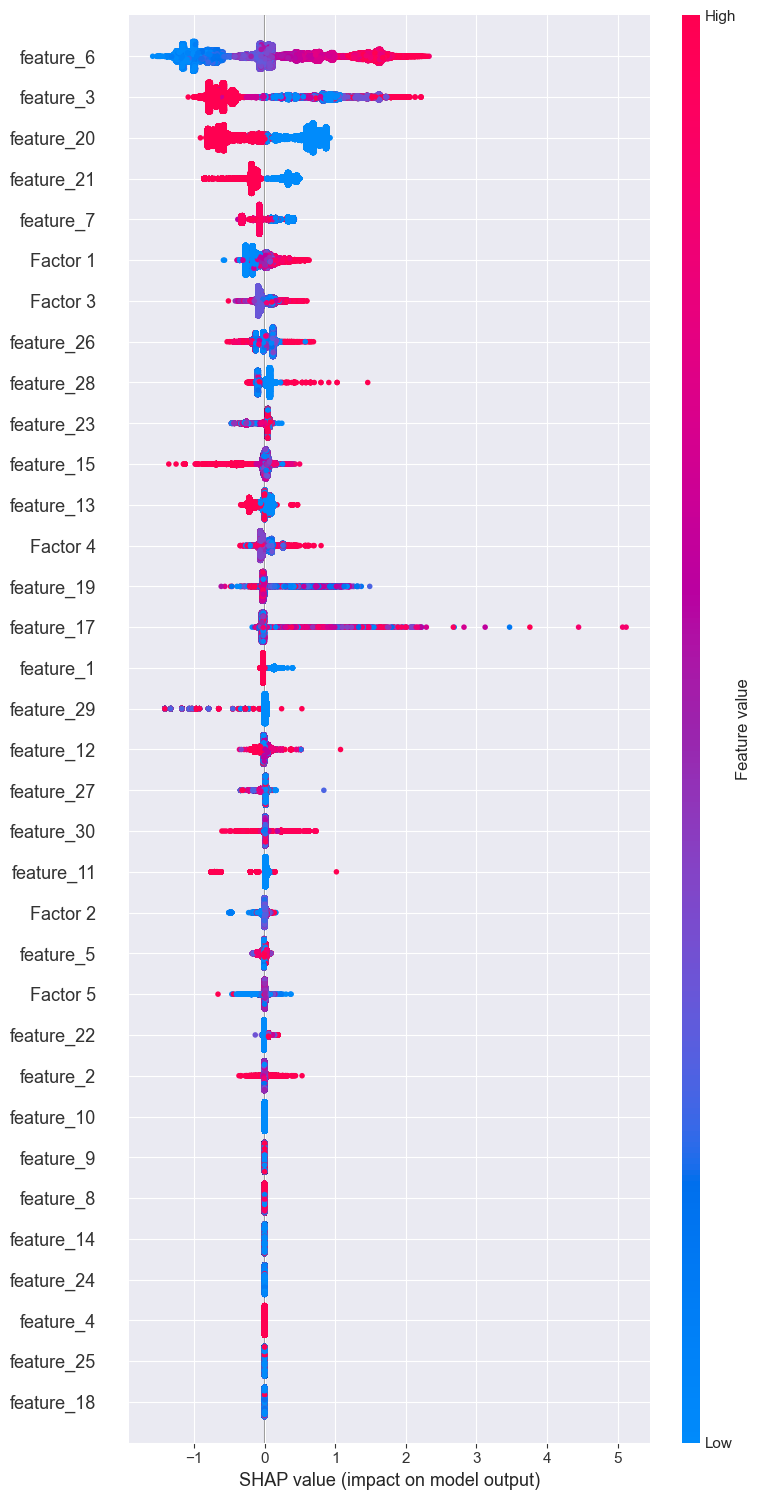

Learning rate set to 0.5
0:	test: 0.6695431	best: 0.6695431 (0)	total: 738ms	remaining: 21.4s
10:	test: 0.8435863	best: 0.8435863 (10)	total: 10.4s	remaining: 17.9s
20:	test: 0.8634497	best: 0.8634497 (20)	total: 17.7s	remaining: 7.58s
29:	test: 0.8704950	best: 0.8711728 (25)	total: 27.8s	remaining: 0us

bestTest = 0.8711728043
bestIteration = 25

Shrink model to first 26 iterations.
                    feature_6                     : 31.562%
                     Factor 3                     : 16.836%
                    feature_3                     : 8.366%
                    feature_9                     : 6.209%
                    feature_12                    : 6.143%
                    feature_2                     : 5.498%
                    feature_8                     : 3.689%
                     Factor 1                     : 3.684%
                    feature_26                    : 3.224%
                    feature_19                    : 2.910%
                    f

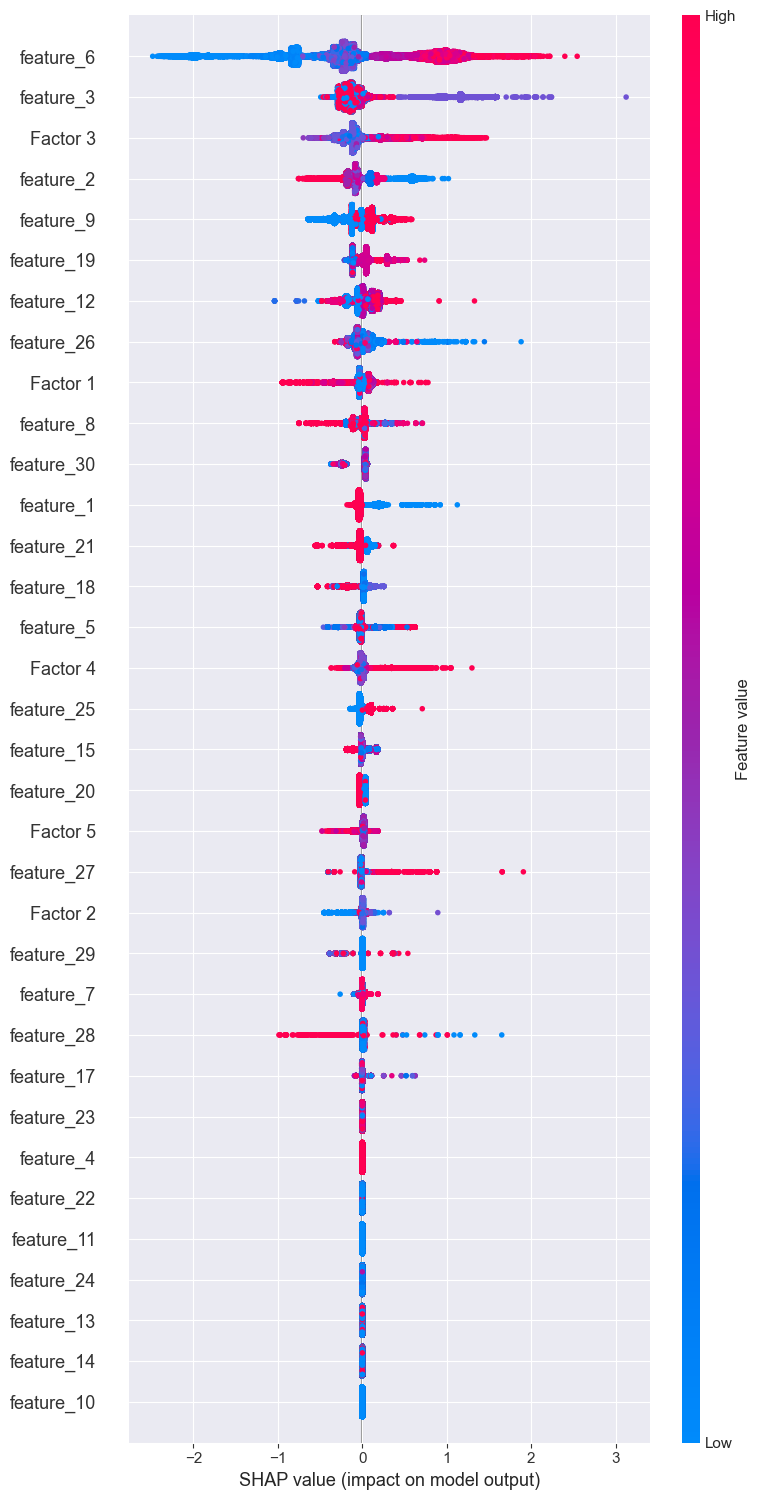

Learning rate set to 0.5
0:	test: 0.9746142	best: 0.9746142 (0)	total: 2.94s	remaining: 1m 25s
10:	test: 0.9983851	best: 0.9983863 (9)	total: 25.1s	remaining: 43.4s
20:	test: 0.9984791	best: 0.9984791 (20)	total: 39.4s	remaining: 16.9s
29:	test: 0.9985402	best: 0.9985455 (27)	total: 56.8s	remaining: 0us

bestTest = 0.9985455132
bestIteration = 27

Shrink model to first 28 iterations.
                    feature_12                    : 66.843%
                    feature_15                    : 7.474%
                    feature_3                     : 6.240%
                    feature_30                    : 3.778%
                    feature_6                     : 3.003%
                     Factor 2                     : 2.706%
                    feature_27                    : 2.296%
                     Factor 4                     : 1.238%
                    feature_13                    : 0.729%
                    feature_18                    : 0.723%
                     F

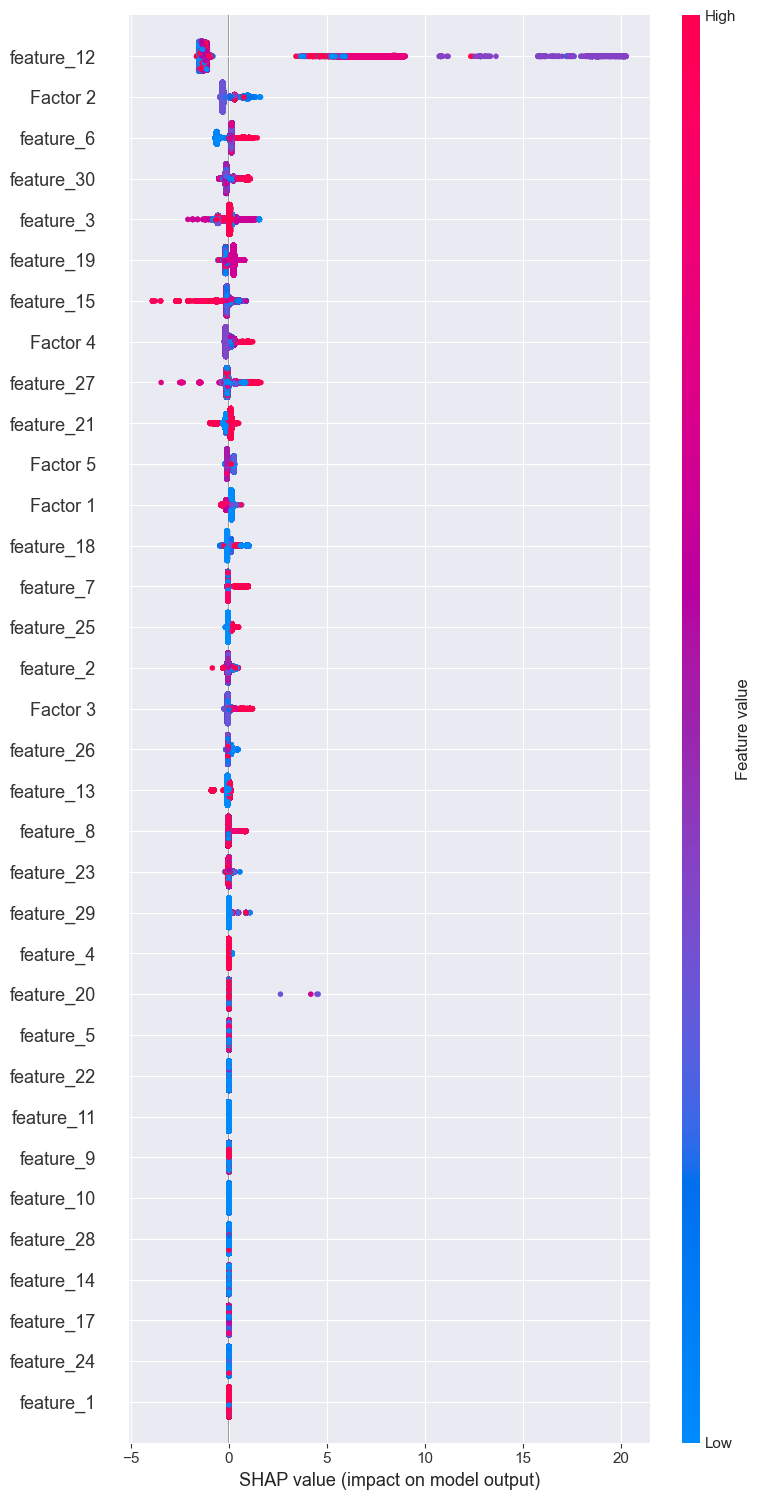

In [5]:
for index, target in enumerate([target_1, target_2, target_3]):
    x_train, x_val, y_train, y_val = train_test_split(df, target, test_size=0.1, shuffle=True, random_state=42)
    model = CatBoostClassifier(
        iterations=30,
        early_stopping_rounds=20,
        use_best_model=True,
        cat_features=categorical_features,
        eval_metric='AUC',
        verbose=10,
        one_hot_max_size=5,
        random_state=115,
    )
    model.fit(x_train, y_train, eval_set=(x_val, y_val))
    
    with open(f"model_{index + 1}.pkl", "wb") as file:
        pickle.dump(model, file)
    
    print_features(model)
    
    shap_values = shap.TreeExplainer(model).shap_values(x_val)
    shap.summary_plot(shap_values, x_val, max_display=50)


<AxesSubplot: >

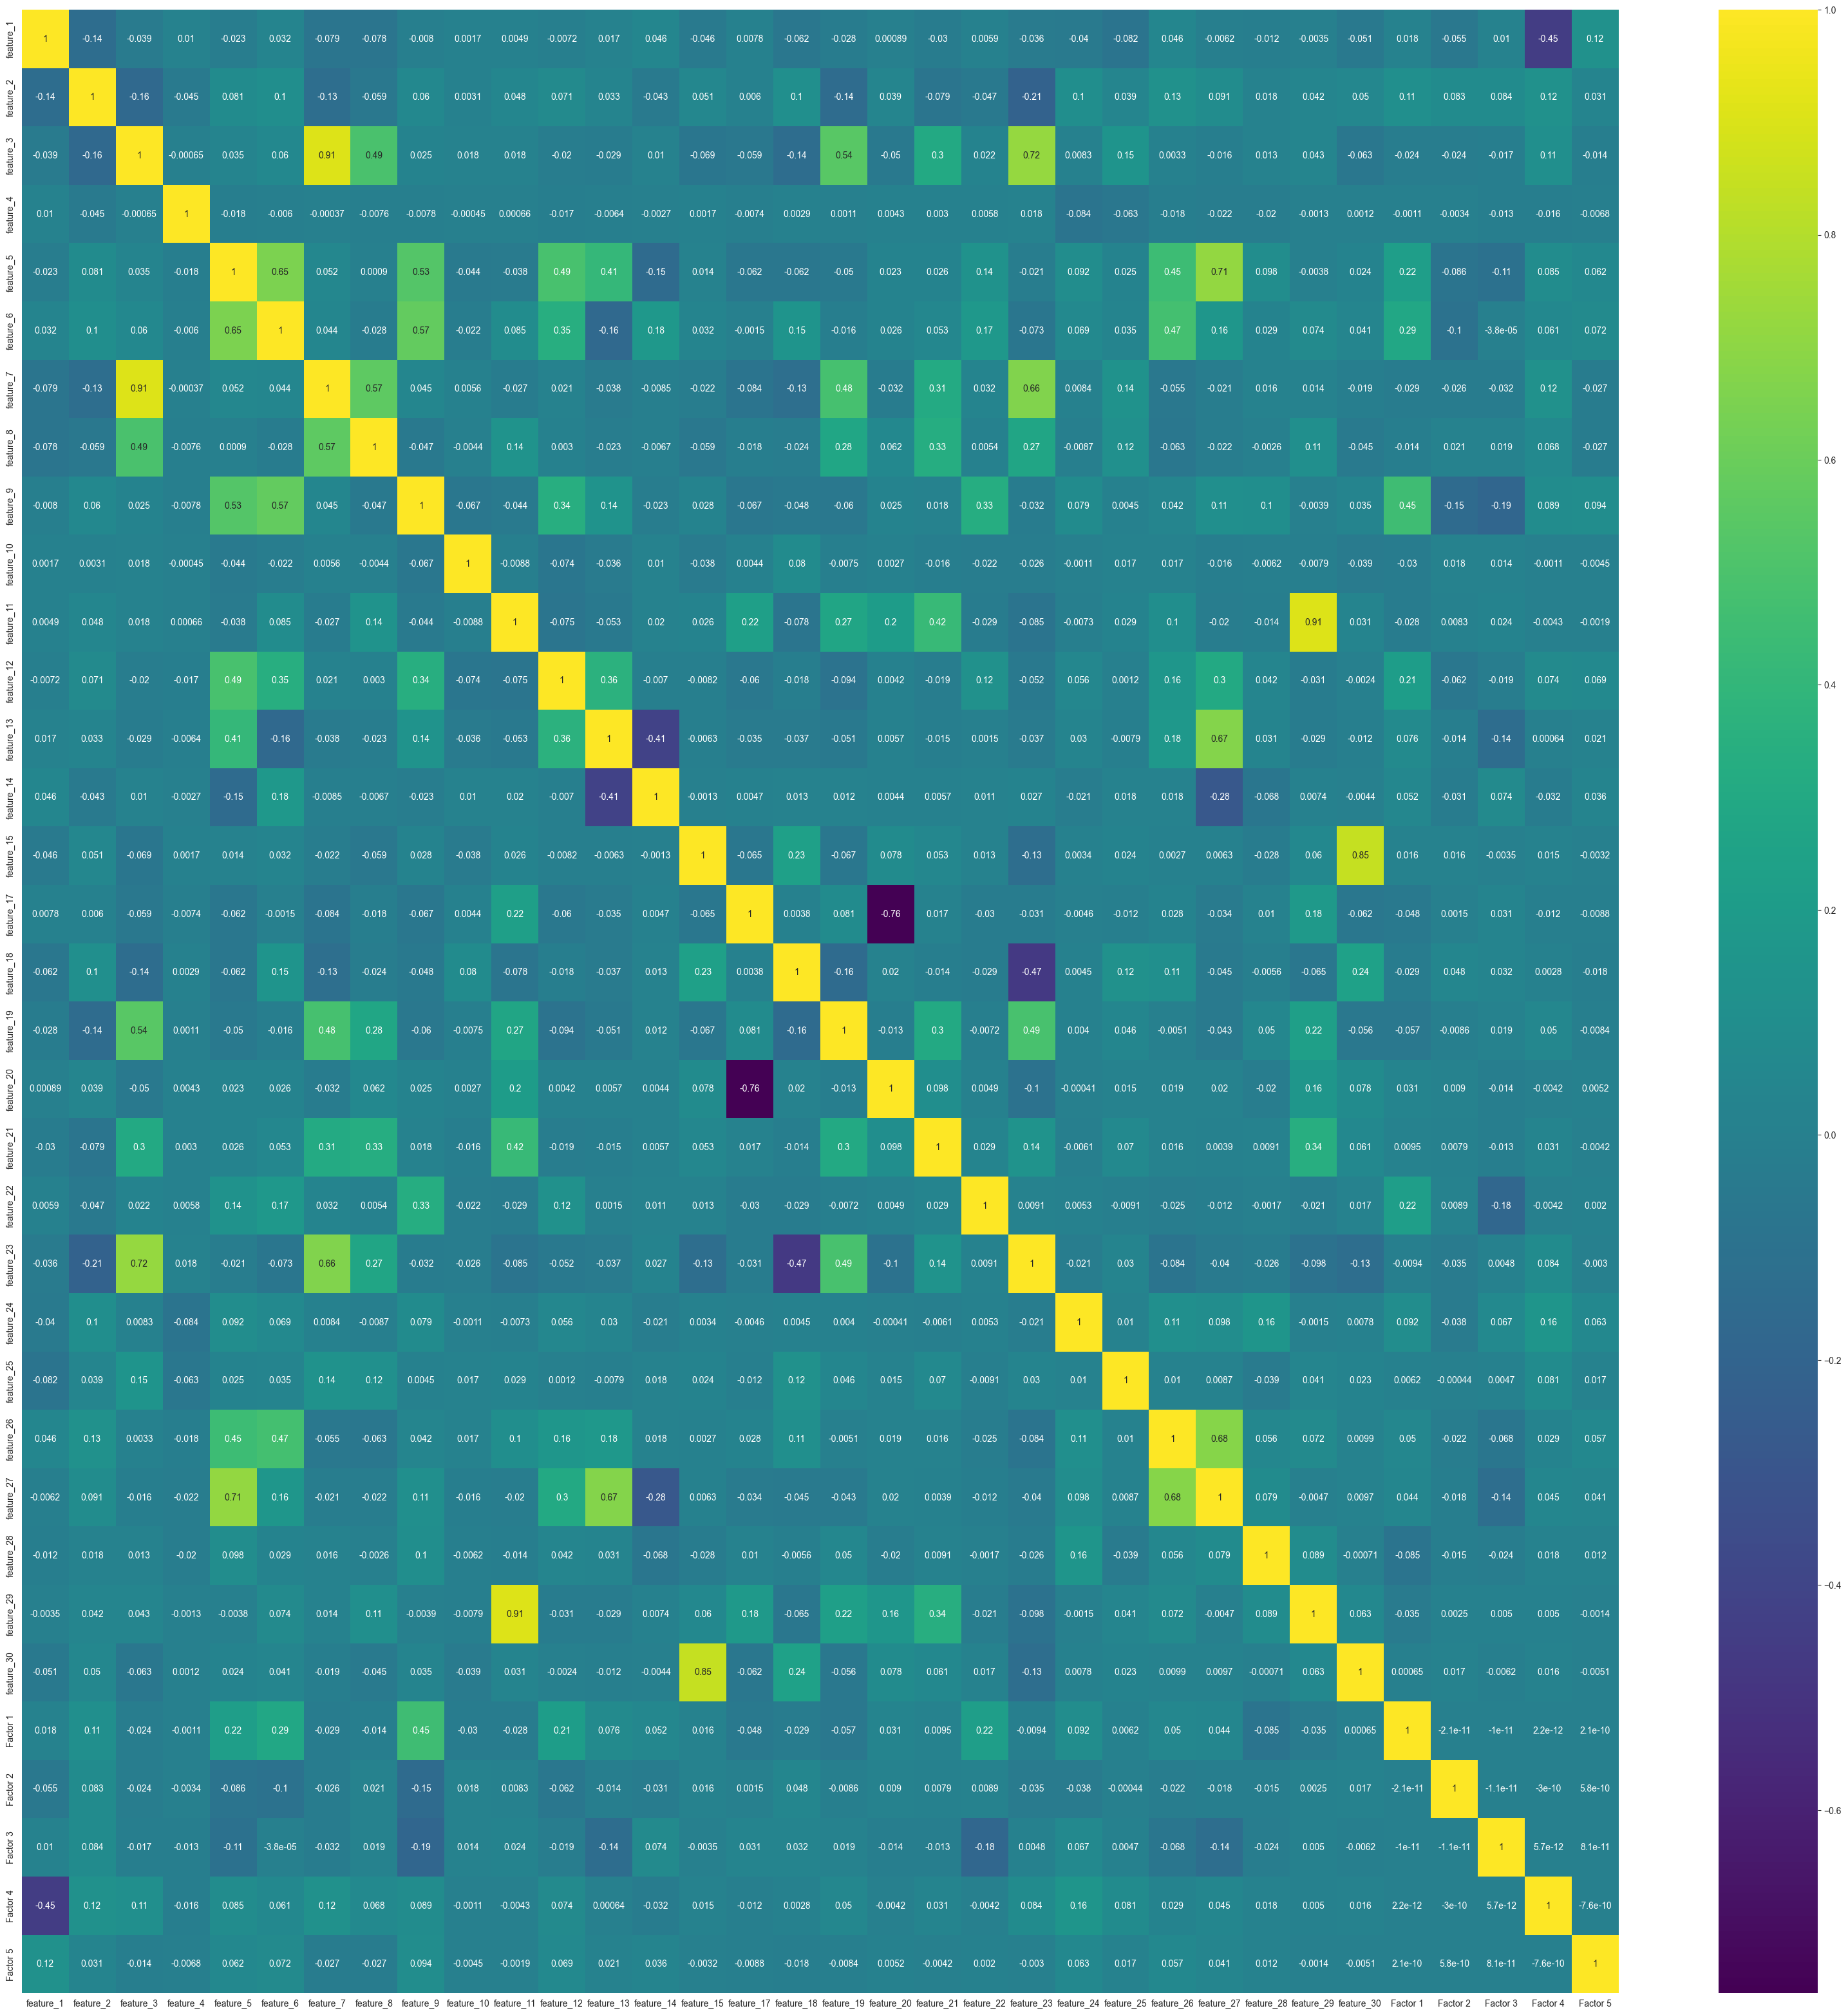

In [8]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(data=corr, cmap='viridis', annot=True, ax=ax)